In [1]:
# Import required modules
from rms_norm import create_rmsnorm_analyzer, print_flop_analysis
from plotting_utils import create_complete_analysis_report

# RMSNorm Analysis Notebook

This notebook provides comprehensive performance analysis for the RMSNorm module, including:
- FLOP calculations and memory bandwidth analysis
- Scaling behavior across batch sizes, sequence lengths, and embedding dimensions  
- Performance visualizations and optimization insights

The computational code has been moved to `rms_norm.py` for better modularity and reuse.

In [2]:
# FLOP Analysis for Common Configurations

# Define typical transformer configurations
configurations = [
    {"name": "Small", "B": 8, "S": 512, "D": 768},
    {"name": "Base", "B": 16, "S": 1024, "D": 1024},
    {"name": "Large", "B": 32, "S": 2048, "D": 4096},
    {"name": "XL", "B": 64, "S": 4096, "D": 8192},
]

# Print FLOP analysis
print_flop_analysis(configurations)

RMSNorm FLOP Analysis
Config   B    S      D      Total FLOPs 
--------------------------------------------------
Small    8    512    768    12.59M      
Base     16   1024   1024   67.14M      
Large    32   2048   4096   1.07G       
XL       64   4096   8192   8.59G       

Detailed FLOP Breakdown (Small config)
Input shape: (8, 512, 768)
x.pow(2):           3,145,728 FLOPs
mean(dim=-1):       3,145,728 FLOPs
+ eps:              4,096 FLOPs
rsqrt():            4,096 FLOPs
x * rsqrt_result:   3,145,728 FLOPs
result * weight:    3,145,728 FLOPs
------------------------------
Total:              12,591,104 FLOPs (12.59M)
Approximation:      ≈ 4 × B × S × D = 12,582,912 FLOPs


In [3]:
# Quick Memory Bandwidth Test

import torch

if torch.cuda.is_available():
    print("Running quick memory bandwidth test on a few configurations...")

    # Create RMSNorm analyzer
    analyzer = create_rmsnorm_analyzer()

    # Quick test configurations (cache-busting sizes)
    quick_configs = [
        (32, 2048, 4096),  # ~0.5GB
        (64, 2048, 4096),  # ~1.0GB
        (32, 4096, 4096),  # ~1.0GB
    ]

    from rms_norm import BenchmarkConfig

    print(f"\nTesting {len(quick_configs)} cache-busting configurations:")
    print("-" * 60)

    for i, (B, S, D) in enumerate(quick_configs, 1):
        tensor_size_gb = B * S * D * 2 / 1e9  # FP16
        print(f"\nConfig {i}: B={B}, S={S}, D={D}")
        print(f"Tensor size: {tensor_size_gb:.2f} GB")

        try:
            # Test with fast config for demonstration
            config = BenchmarkConfig(warmup_runs=3, benchmark_runs=10)
            bandwidth, actual_size = analyzer.safe_benchmark(B, S, D, config)

            if bandwidth > 0:
                utilization = (bandwidth / 1008) * 100  # RTX 4090 peak
                print(
                    f"✅ Bandwidth: {bandwidth:.1f} GB/s ({utilization:.1f}% utilization)"
                )
            else:
                print("❌ OOM or benchmark failed")

        except Exception as e:
            print(f"❌ Error: {e}")

        # Clear memory
        torch.cuda.empty_cache()

else:
    print("CUDA not available - skipping bandwidth test")

Running quick memory bandwidth test on a few configurations...

Testing 3 cache-busting configurations:
------------------------------------------------------------

Config 1: B=32, S=2048, D=4096
Tensor size: 0.54 GB
✅ Bandwidth: 730.5 GB/s (72.5% utilization)

Config 2: B=64, S=2048, D=4096
Tensor size: 1.07 GB
✅ Bandwidth: 743.8 GB/s (73.8% utilization)

Config 3: B=32, S=4096, D=4096
Tensor size: 1.07 GB
✅ Bandwidth: 670.5 GB/s (66.5% utilization)


In [4]:
# Comprehensive Analysis with Visualizations

import torch

if torch.cuda.is_available():
    print("Running comprehensive RMSNorm bandwidth analysis...")
    print(
        "This will test 1000+ parameter combinations and generate detailed visualizations."
    )
    print(
        "⚠️  This may take 30-90 minutes depending on GPU memory and configuration count."
    )
    print("\nTo run the analysis, uncomment and execute the code below:")

    analysis_code = """
# Create RMSNorm analyzer
analyzer = create_rmsnorm_analyzer()

# Run comprehensive analysis with expanded parameter ranges
from rms_norm import BenchmarkConfig

config = BenchmarkConfig(
    warmup_runs=1,           # Fast for large-scale testing
    benchmark_runs=3,        # Fast for large-scale testing  
    memory_factor=6,         # RMSNorm memory access pattern
    percentile_filter=(0.1, 0.9)  # Filter outliers
)

# Run the analysis
df_results = analyzer.run_comprehensive_analysis(
    config=config,
    expanded_ranges=True,    # Use expanded parameter ranges (powers of 2 + multiples)
    peak_bandwidth_gbps=1008 # RTX 4090 theoretical peak
)

# Create complete analysis report with plots
create_complete_analysis_report(
    df_results,
    module_name="RMSNorm",
    peak_bandwidth_gbps=1008,
    show_plots=True,
    top_n=15
)

# Store results for further analysis
globals()["bandwidth_results"] = df_results
print(f"\\nResults stored in 'bandwidth_results' variable with {len(df_results):,} configurations")
"""

    print(f"Code to run comprehensive analysis:")
    print("-" * 50)
    print(analysis_code)

else:
    print("CUDA not available - cannot run comprehensive GPU analysis")
    print("The analysis requires a CUDA-capable GPU for memory bandwidth measurements.")

Running comprehensive RMSNorm bandwidth analysis...
This will test 1000+ parameter combinations and generate detailed visualizations.
⚠️  This may take 30-90 minutes depending on GPU memory and configuration count.

To run the analysis, uncomment and execute the code below:
Code to run comprehensive analysis:
--------------------------------------------------

# Create RMSNorm analyzer
analyzer = create_rmsnorm_analyzer()

# Run comprehensive analysis with expanded parameter ranges
from rms_norm import BenchmarkConfig

config = BenchmarkConfig(
    warmup_runs=1,           # Fast for large-scale testing
    benchmark_runs=3,        # Fast for large-scale testing  
    memory_factor=6,         # RMSNorm memory access pattern
    percentile_filter=(0.1, 0.9)  # Filter outliers
)

# Run the analysis
df_results = analyzer.run_comprehensive_analysis(
    config=config,
    expanded_ranges=True,    # Use expanded parameter ranges (powers of 2 + multiples)
    peak_bandwidth_gbps=1008 # RTX 4

Comprehensive Memory Bandwidth Analysis
GPU: NVIDIA GeForce RTX 4090
Available Memory: 25.4 GB
Module: RMSNorm
Memory Factor: 6x

Batch sizes (19): [16, 24, 32, 48, 64]...[4096, 6144, 8192]
Sequence lengths (37): [128, 160, 192, 224, 256]...[49152, 57344, 65536]
Embedding dimensions (33): [256, 320, 384, 448, 512]...[49152, 57344, 65536]

Total combinations: 23,199
Viable configurations: 14,119
Memory range: 0.001 - 22.55 GB

Running benchmarks on 14,119 configurations...


Benchmarking:   0%|          | 0/14119 [00:00<?, ?config/s]


Completed: 10,283 successful, 3,836 OOM
Filtered results: 8,225 / 10,283 kept


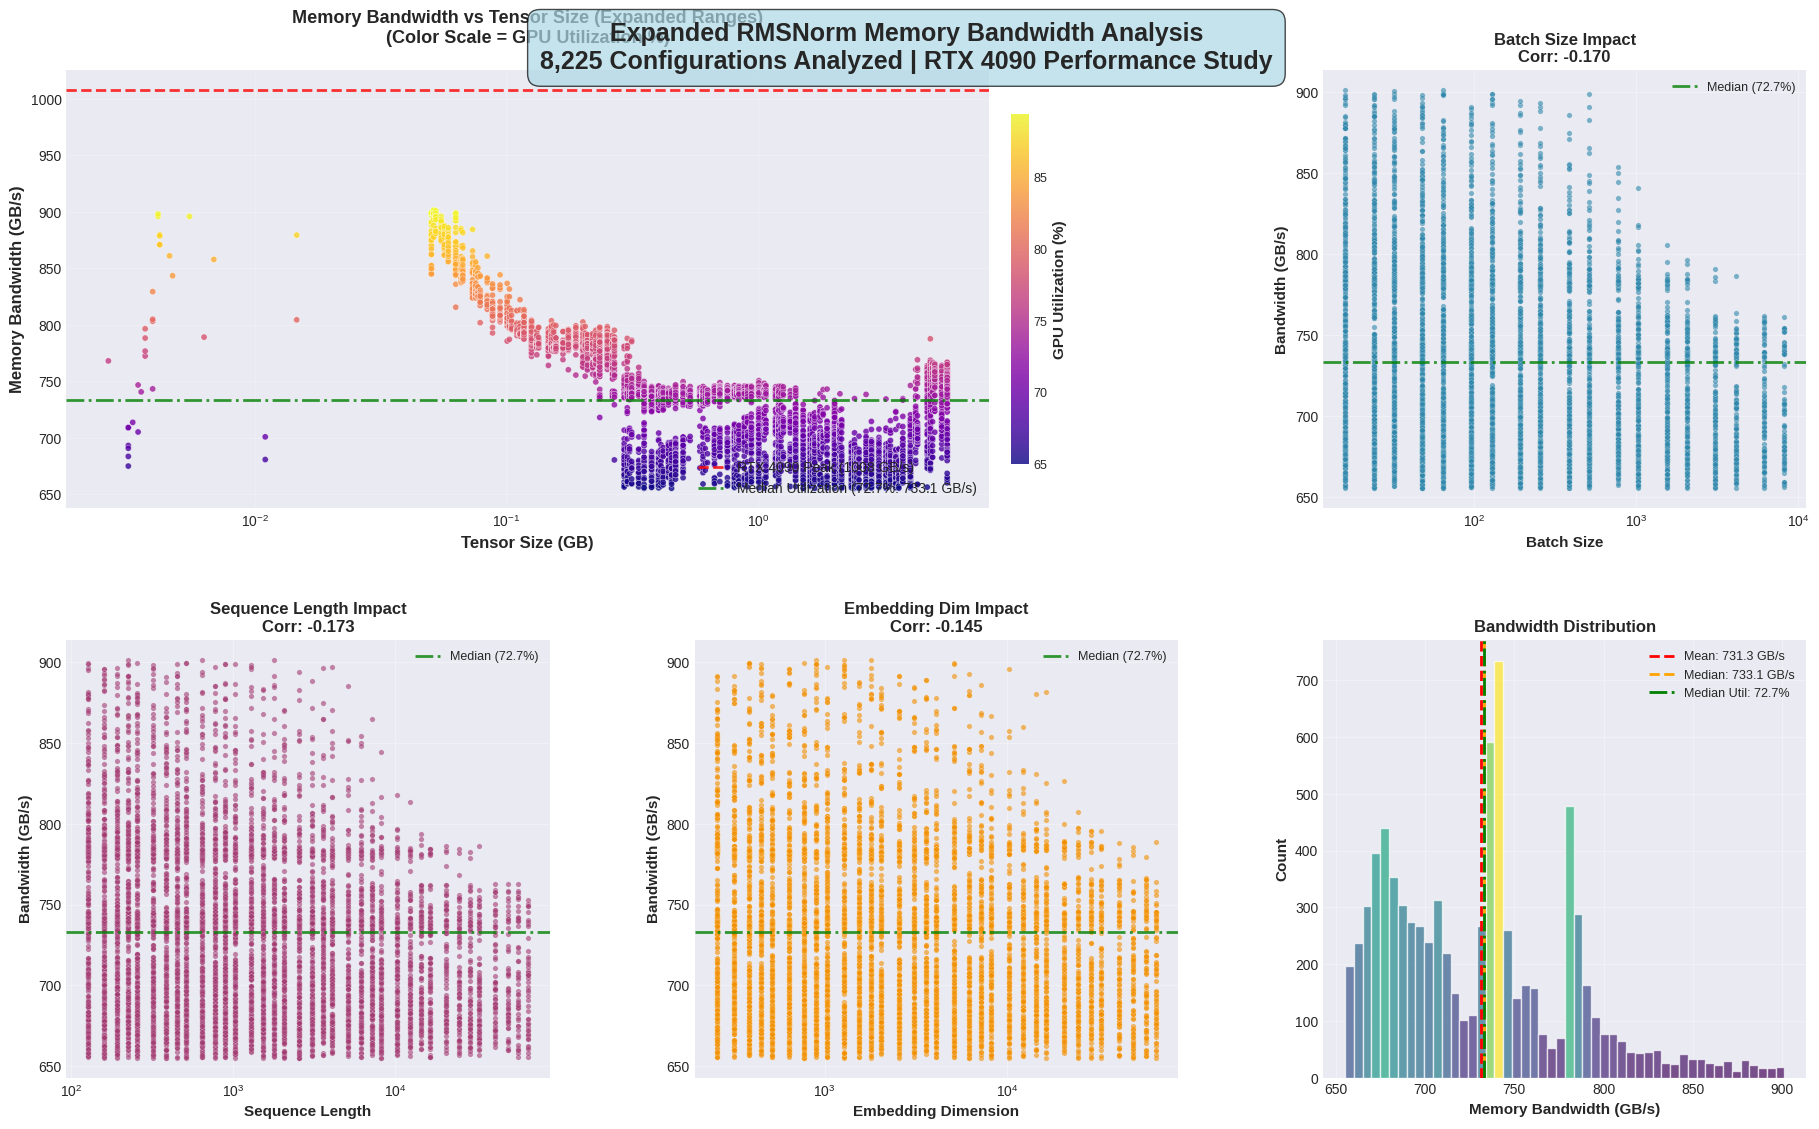


RMSNORM ANALYSIS RESULTS
Overall Performance:
   Best bandwidth: 901.4 GB/s (89.4%)
   Average bandwidth: 731.3 GB/s (72.5%)
   Median bandwidth: 733.1 GB/s (72.7%)
   Bandwidth std dev: 51.4 GB/s

BEST CONFIGURATION:
   Bandwidth: 901.4 GB/s (89.4%)
   Shape: B=16, S=1792, D=896
   Tensor size: 0.05 GB

Scaling Analysis:
   Batch size correlation with bandwidth: -0.170
   Sequence length correlation with bandwidth: -0.173
   Embedding dim correlation with bandwidth: -0.145
   Tensor size correlation with bandwidth: -0.397

TOP 15 CONFIGURATIONS:
Rank Batch    SeqLen   EmbDim   Bandwidth    Util%    Size(GB)
-------------------------------------------------------------------------------------
***  1       16      1792       896       901.4 GB/s    89.4     0.05
***  2       64       224      1792       901.4 GB/s    89.4     0.05
***  3       32       640      1280       900.9 GB/s    89.4     0.05
***  4       64       512       768       899.3 GB/s    89.2     0.05
***  5      128  

In [5]:
# Create RMSNorm analyzer
analyzer = create_rmsnorm_analyzer()

# Run comprehensive analysis with expanded parameter ranges
from rms_norm import BenchmarkConfig

config = BenchmarkConfig(
    warmup_runs=1,  # Fast for large-scale testing
    benchmark_runs=3,  # Fast for large-scale testing
    memory_factor=6,  # RMSNorm memory access pattern
    percentile_filter=(0.1, 0.9),  # Filter outliers
)

# Run the analysis
df_results = analyzer.run_comprehensive_analysis(
    config=config,
    expanded_ranges=True,  # Use expanded parameter ranges (powers of 2 + multiples)
    peak_bandwidth_gbps=1008,  # RTX 4090 theoretical peak
)

# Create complete analysis report with plots
create_complete_analysis_report(
    df_results,
    module_name="RMSNorm",
    peak_bandwidth_gbps=1008,
    show_plots=True,
    top_n=15,
)

# Store results for further analysis
globals()["bandwidth_results"] = df_results
print(
    f"\nResults stored in 'bandwidth_results' variable with {len(df_results):,} configurations"
)